# NLP

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Carga de datos

In [26]:
url="https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv"

data=pd.read_csv(url)
data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


Transformamos la variable Spam en numérica

In [27]:
data["is_spam"] = data["is_spam"].apply(lambda x: 1 if x else 0).astype(int)
data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


Contamos cuántas clases hay de cada para ver si está balanceado:

In [28]:
print(data.shape)
print(f"Spam: {len(data.loc[data.is_spam == 1])}")
print(f"No spam: {len(data.loc[data.is_spam == 0])}")

(2999, 2)
Spam: 696
No spam: 2303


Eliminamos duplicados:

In [29]:
data.duplicated().sum()

630

In [31]:
data = data.drop_duplicates()
data = data.reset_index(inplace = False, drop = True)
print(data.shape)
data.duplicated().sum()

(2369, 2)


0

Preprocesamiento de enlaces:

* Eliminamos signos de puntuación y espacios en blanco.
* Convertimos a minúsculas

In [33]:
import regex as re

def preprocess_text(text):
    # Eliminar cualquier caracter que no sea una letra (a-z) o un espacio en blanco ( )
    text = re.sub(r'[^a-z ]', " ", text)
    
    # Eliminar espacios en blanco
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # Reducir espacios en blanco múltiples a uno único
    text = re.sub(r'\s+', " ", text.lower())

    # Eliminar tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split()

data["url_prep"] = data["url"].apply(preprocess_text)
data.head()

,url,is_spam,url_prep
0,https://briefingday.us8.list-manage.com/unsubs...,1,"[https, briefingday, us, list, manage, com, un..."
1,https://www.hvper.com/,1,"[https, www, hvper, com]"
2,https://briefingday.com/m/v4n3i4f3,1,"[https, briefingday, com, v, i]"
3,https://briefingday.com/n/20200618/m#commentform,0,"[https, briefingday, com, m, commentform]"
4,https://briefingday.com/fan,1,"[https, briefingday, com, fan]"


Realizamos la lemmatización del texto y eliminamos las stop words:

In [35]:
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
download("wordnet")
lemmatizer = WordNetLemmatizer()

download("stopwords")
stop_words = stopwords.words("english")

def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

data["url_prep_2"] = data["url_prep"].apply(lemmatize_text)
data.head()

[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,url,is_spam,url_prep,url_prep_2
0,https://briefingday.us8.list-manage.com/unsubs...,1,"[https, briefingday, us, list, manage, com, un...","[http, briefingday, list, manage, unsubscribe]"
1,https://www.hvper.com/,1,"[https, www, hvper, com]","[http, hvper]"
2,https://briefingday.com/m/v4n3i4f3,1,"[https, briefingday, com, v, i]","[http, briefingday]"
3,https://briefingday.com/n/20200618/m#commentform,0,"[https, briefingday, com, m, commentform]","[http, briefingday, commentform]"
4,https://briefingday.com/fan,1,"[https, briefingday, com, fan]","[http, briefingday]"


Visualizamos en una nube de palabras para ver los terminos mas usados

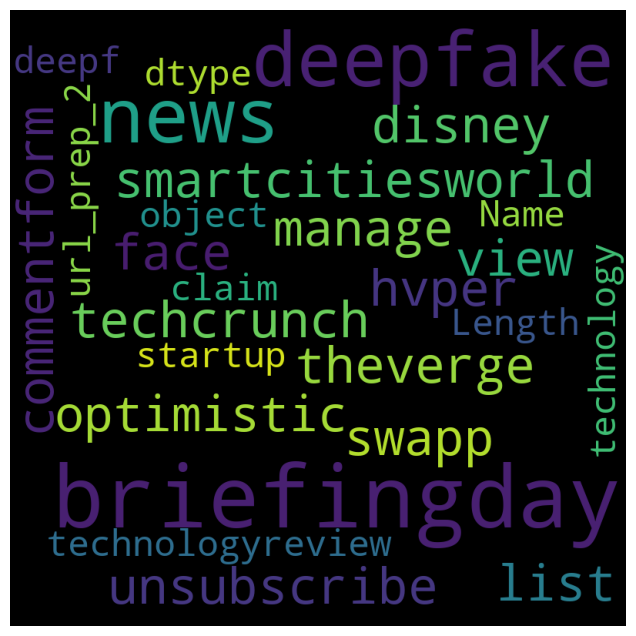

In [37]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800, background_color = "black", max_words = 1000, min_font_size = 20, random_state = 42)\
    .generate(str(data["url_prep_2"]))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Transformamos a números

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

tokens_list = data["url_prep_2"]
tokens_list = [" ".join(tokens) for tokens in tokens_list]

vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)
X = vectorizer.fit_transform(tokens_list).toarray()
y = data["is_spam"]

X[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Dividimos en muestra de entrenamiento y test

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Entrenamos el modelo

In [40]:
from sklearn.svm import SVC

model = SVC(kernel = "linear", random_state = 42)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

Hacemos las previsiones y calculamos el accuracy inicial

In [43]:
y_pred = model.predict(X_test)
y_pred[0:10]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [44]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9514767932489452

Tenemos un accuracy inicial de 95,14% que está muy bien, pero vamos a ver si podemos mejorarlo con hiperparámetros

In [73]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

# Definimos los parámetros que queremos ajustar
hyperparams = {
    "C": list(range(1,10)),
    "kernel": ["linear","rbf","poly"],
    "gamma": ["scale", "auto"],
    "degree": list(range(2, 5)),
        
}

In [74]:
opt_search = GridSearchCV(model, hyperparams, scoring = "accuracy", cv = 5)
opt_search
opt_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(kernel='linear', random_state=42),
             param_grid={'C': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'degree': [2, 3, 4],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy')

In [75]:
best_params = opt_search.best_params_
print("Mejores parámetros encontrados:", best_params)


Mejores parámetros encontrados: {'C': 2, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}


In [77]:

model_grid = SVC(
        C=opt_search.best_params_["C"],
        kernel=opt_search.best_params_["kernel"],
        gamma=opt_search.best_params_["gamma"],
        degree=opt_search.best_params_["degree"]
        )


model_grid.fit(X_train, y_train)
y_grid_pred = model_grid.predict(X_test)
grid_accuracy = accuracy_score(y_test, y_grid_pred)
grid_accuracy

0.959915611814346

Hemos conseguido mejorar un poco el accuracy pasando de un 95,15% a un 95,99%

Guardamos el modelo

In [78]:
from pickle import dump

dump(model_grid, open("NLP_gridModel.sav", "wb"))